In [1]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.exceptions import NotFittedError
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import math

# EDA

In [2]:
df = pd.read_csv("/home/heylucasleao/ols-regression-challenge/data/INFLUD24-03-02-2025.csv", sep=";", encoding="latin1", low_memory=False)

In [3]:
sinais_sintomas = [
    "FEBRE", "TOSSE", "GARGANTA", "DISPNEIA", "DESC_RESP", 
    "SATURACAO", "DIARREIA", "VOMITO", "DOR_ABD", "FADIGA", 
    "PERD_OLFT", "PERD_PALA", "OUTRO_SIN", 
    #"OUTRO_DES"
]
fatores_risco = [
    "FATOR_RISC", 
    #"PUERPERA", 
    "CARDIOPATI", 
    #"HEMATOLOGI", 
    #"SIND_DOWN", 
    #"HEPATICA", 
    "ASMA", 
    "DIABETES", 
    "NEUROLOGIC", 
    "PNEUMOPATI", 
    "IMUNODEPRE", 
    #"RENAL", 
    #"OBESIDADE", 
    #"OBES_IMC", 
    "OUT_MORBI", 
    #"MORB_DESC"
]
vacinacao = [
    "VACINA_COV", 
    #"DOSE_1_COV", 
    #"DOSE_2_COV", 
    #"DOSE_REF", 
    #"DOSE_2REF", 
    #"FAB_COV1", 
    #"FAB_COV2", 
    #"FAB_COVRF", 
    #"FAB_COVRF2", 
    #"LOTE_1_COV", 
    #"LOTE_2_COV", 
    #"LOTE_REF", 
    # "LOTE_REF2", 
    #"FNT_IN_COV"
]
tratamento = [
    "ANTIVIRAL", 
    #"TP_ANTIVIR", "OUT_ANTIV", "DT_ANTIVIR", 
    #"TRAV_COV", 
    #"TIPO_TRAV", 
    #"OUT_TRAV", 
    #"DT_TRAV_COV"
]

internacao = [
    "HOSPITAL", 
    #"DT_INTERNA", 
    #"SG_UF_INTE", 
    #"CO_MU_INTE", 
    #"CO_UN_INTE", 
    "UTI", 
    #"DT_ENTUTI", 
    #"DT_SAIDUTI", 
    "SUPORT_VEN"
]
exames = [
    "RAIOX_RES", 
    #"RAIOX_OUT", 
    #"DT_RAIOX", 
    "TOMO_RES", 
   # "TOMO_OUT", 
    #"DT_TOMO", 
    "AMOSTRA", 
    #"DT_COLETA", 
    "TP_AMOSTRA", 
    #"OUT_AMOST"
]
testes_laboratoriais = [
    "RES_AN", 
    #"POS_AN_FLU", 
    #"TP_FLU_AN", 
    #"POS_AN_OUT", 
    #"AN_SARS2", 
    #"AN_VSR", 
    #"AN_PARA1", 
    #"AN_PARA2", 
    #"AN_PARA3", 
    #"AN_ADENO", 
    #"AN_OUTRO", 
    #"DS_AN_OUT"
]
rt_pcr = [
    "PCR_RESUL", 
    #"DT_PCR", 
    "POS_PCRFLU", 
    #"TP_FLU_PCR", 
    #"PCR_FLUASU", 
    #"FLUASU_OUT", 
    #"PCR_FLUBLI", 
    #"FLUBLI_OUT", 
    "POS_PCROUT",
    #"PCR_SARS2", 
    #"PCR_VSR", 
    #"PCR_PARA1", 
    #"PCR_PARA2", 
    #"PCR_PARA3", 
    #"PCR_PARA4", 
    #"PCR_ADENO", 
    #"PCR_METAP", 
    #"PCR_BOCA", 
    #"PCR_RINO", 
    #"PCR_OUTRO", 
    #"DS_PCR_OUT"
]


In [4]:
columns = (sinais_sintomas 
            + fatores_risco 
            + vacinacao 
            + tratamento 
            + internacao
            + exames
            + testes_laboratoriais
            + rt_pcr)
target = "CASO_SRAG"

In [5]:
df = df[columns + ["CASO_SRAG"]]

In [6]:
is_null = df.isnull().sum()
remove_features = is_null[is_null / len(df) > 0.70].index.tolist()
df = df[df.columns.drop(remove_features)]

In [7]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

IMUNODEPRE    0.695856
NEUROLOGIC    0.691754
PNEUMOPATI    0.691476
ASMA          0.687209
POS_PCRFLU    0.685441
DIABETES      0.676996
POS_PCROUT    0.670232
OUT_MORBI     0.666411
CARDIOPATI    0.658409
TOMO_RES      0.413032
RAIOX_RES     0.311369
OUTRO_SIN     0.273663
PERD_PALA     0.259017
PERD_OLFT     0.257681
DOR_ABD       0.249405
GARGANTA      0.242386
DIARREIA      0.240408
VOMITO        0.233641
FADIGA        0.233330
ANTIVIRAL     0.191679
SATURACAO     0.150790
DESC_RESP     0.119487
DISPNEIA      0.110783
SUPORT_VEN    0.109432
CASO_SRAG     0.109151
FEBRE         0.105394
RES_AN        0.102488
UTI           0.100743
PCR_RESUL     0.078279
TP_AMOSTRA    0.075052
TOSSE         0.065053
HOSPITAL      0.022456
AMOSTRA       0.020666
VACINA_COV    0.000191
FATOR_RISC    0.000000
dtype: float64

In [8]:


def plot_histograms_grid(
    df, 
    max_plots_per_row=5, 
    height=300, 
    width=600, 
    title="Histograms Grid"
):
    """
    Creates a grid of histograms for all columns in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the data to plot
    max_plots_per_row : int, optional
        Maximum number of plots per row (default: 5)
    plot_height : int, optional
        Height in pixels for each individual plot row (default: 300)
    plot_width : int, optional
        Optional fixed width for the entire figure
    title : str, optional
        Title for the overall figure (default: "Histograms Grid")
    
    Returns:
    --------
    plotly.graph_objs._figure.Figure
        Plotly Figure object containing the histograms
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    
    num_columns = len(df.columns)
    if num_columns == 0:
        raise ValueError("DataFrame has no columns to plot")
    
    n_rows = math.ceil(num_columns / max_plots_per_row)
    n_cols = min(num_columns, max_plots_per_row)
    
    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        subplot_titles=df.columns,
        horizontal_spacing=0.1,
        vertical_spacing=0.2/n_rows
    )
    
    for i, column in enumerate(df.columns):
        row = (i // n_cols) + 1
        col = (i % n_cols) + 1
        
        fig.add_trace(
            go.Histogram(x=df[column], name=column),
            row=row, col=col
        )
    
    total_height = n_rows * height
    
    fig.update_layout(
        title_text=title,
        showlegend=False,
        height=total_height,
        width=width,
        margin=dict(t=100 if title else 50)
    )
    
    fig.update_annotations(
        font_size=10,
        yshift=10
    )
    
    return fig



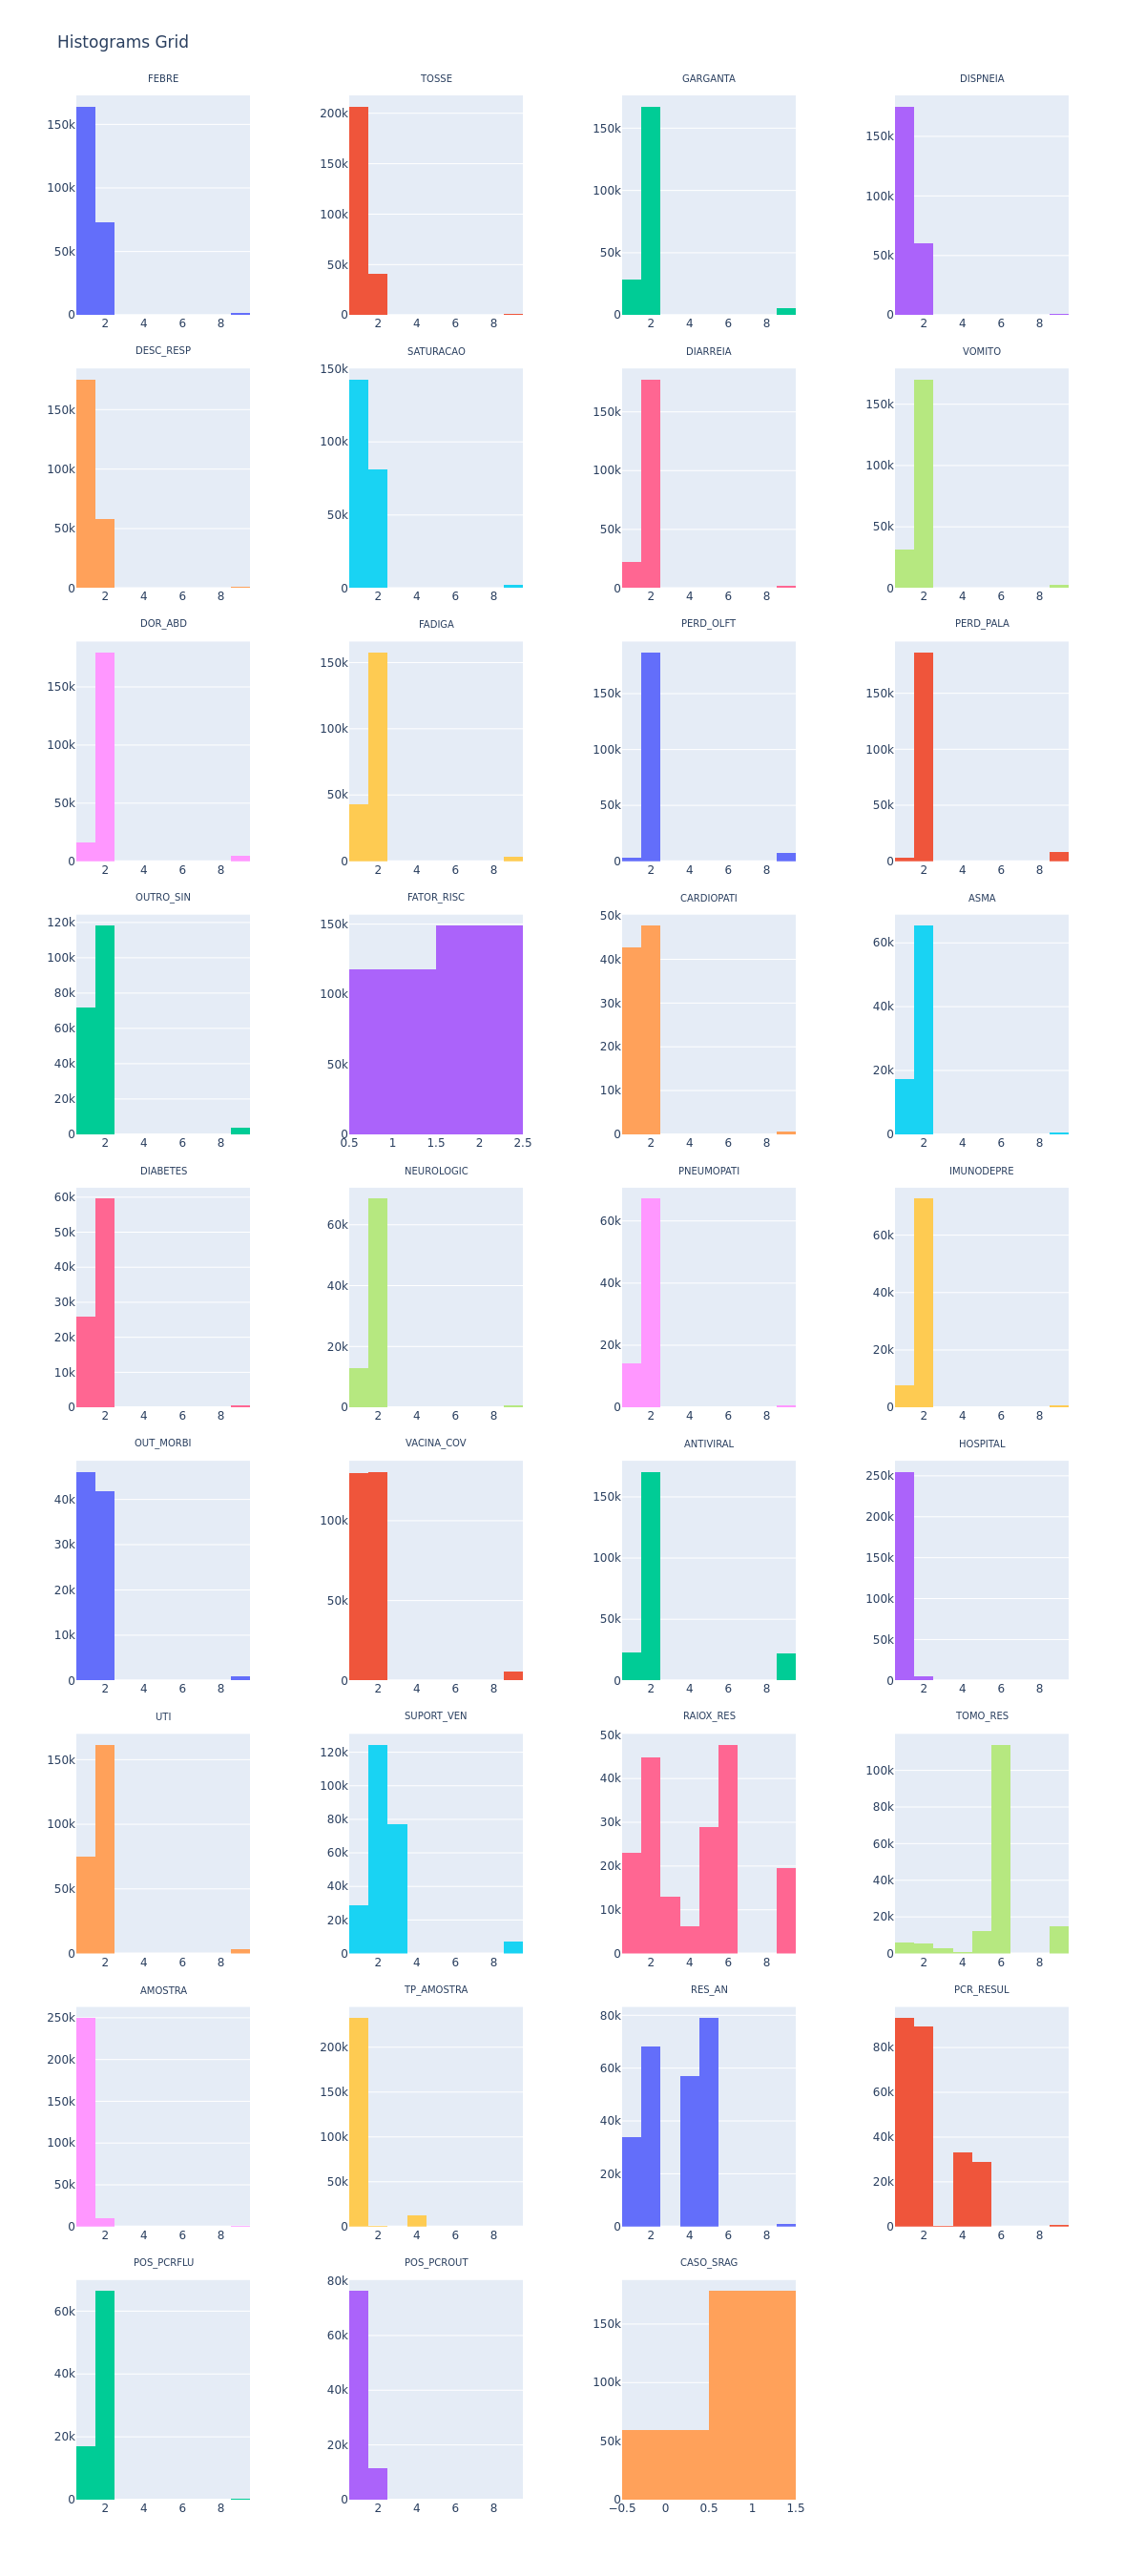

In [9]:
fig = plot_histograms_grid(df, max_plots_per_row=4, width=1200)
fig.show("png")

In [10]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

In [11]:
df = df.fillna(9)
df = df.replace({9: -1})
df = pd.get_dummies(df, columns=df.columns.drop("CASO_SRAG"), drop_first=True)
df = df.astype(int)

## Partialling-Out / Residualization (FWL Theorem)

In [12]:
class PartiallingOutRegressor(BaseEstimator, RegressorMixin):
    """
    Implements partialling-out (regression residualization) technique for linear models.
    
    This technique removes the linear effect of a set of covariates before estimating
    the relationship between the target variable and features of interest.
    
    Parameters:
    -----------
    fit_intercept : bool, optional (default=True)
        Whether to calculate the intercept for the internal linear model.
        If False, no intercept will be used in calculations.
        
    Attributes:
    ----------
    model_ : sklearn.linear_model.LinearRegression
        The internal linear model used for residual calculation.
        
    feature_names_ : list or None
        Names of features (only available when X is a DataFrame).
        
    Examples:
    --------
    >>> import numpy as np
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_features=3, noise=0.1)
    >>> por = PartiallingOutRegressor().fit(X[:, [0,1]], y)
    >>> residuals = por.transform(X[:, [0,1]], y)
    >>> # The residuals can now be used in subsequent analysis
    
    Notes:
    ------
    - Partialling-out is commonly used in econometrics ("net of" effects)
    - Mathematically equivalent to obtaining residuals from y ~ X regression
    - Particularly useful for removing confounder effects before analysis
    """
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.model_ = None 
        
    def fit(self, X, y):
        """
        Fit the residualization model.
        
        Parameters:
        -----------
        X : array-like, DataFrame or sparse matrix of shape (n_samples, n_features)
            Features used to calculate target residuals.
            
        y : array-like of shape (n_samples,)
            Target values.
            
        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
            
        self.model_ = LinearRegression(fit_intercept=self.fit_intercept)
        self.model_.fit(X, y)
        
        return self
    
    def transform(self, X, y):
        """
        Calculate target residuals after removing linear effects of features.
        
        Parameters:
        -----------
        X : array-like, DataFrame or sparse matrix of shape (n_samples, n_features)
            Features used for residual calculation.
            
        y : array-like of shape (n_samples,)
            Target values to be residualized.
            
        Returns:
        --------
        residuals : array of shape (n_samples,)
            Residuals from y ~ X regression (y values with linear effect of X removed).
            
        Raises:
        -------
        NotFittedError
            If the model hasn't been fitted prior to transformation.
        """
        if self.model_ is None:
            raise NotFittedError("This model must be fitted before transformation.")
                    
        residuals = y - self.model_.predict(X)
        return residuals
    
    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        
        Parameters:
        -----------
        **params : dict
            Parameters to set (name=value).
            
        Returns:
        --------
        self : object
            The estimator instance.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [13]:
def create_residuals_mapping(symptoms_list):
    """
    Cria um dicionário de mapeamento de resíduos onde cada chave é um sintoma
    e o valor é a lista de todos os outros sintomas que ainda não foram incluídos.
    
    Args:
        symptoms_list: Lista de sintomas (ex: sinais_sintomas)
    
    Returns:
        Dicionário no formato {sintoma: [outros_sintomas_restantes]}
    """
    residuals_mapping = {}
    accumulated_exclusions = []
    
    for symptom in symptoms_list:
        predictors = [x for x in symptoms_list if x not in accumulated_exclusions + [symptom]]
        if len(predictors) == 0:
            break
        residuals_mapping[symptom] = predictors
        accumulated_exclusions.append(symptom)
    
    return residuals_mapping

def training_multiple_residual_models(data, residuals):
    residual_models = {}
    for features, target in residuals:
        X = np.asarray(data)
        y = np.asarray(data)
        residual_model = PartiallingOutRegressor()
        residual_models[target] = residual_model.fit(X[:, features], y[:, target])
    return residual_models

In [14]:
def preprocessing(df: pd.DataFrame, residuals, models):
    df = df.copy()
    for features, target in residuals:
        X = np.asarray(df.iloc[:, features])
        y = np.asarray(df.iloc[:, target])
        df.iloc[:, target] = models[target].transform(X, y)
    return df

In [15]:
get_index = df.columns.get_indexer

In [16]:
dummy_sintomas = []
for sintoma in sinais_sintomas:
    dummy = df.columns[df.columns.str.startswith(sintoma)]
    dummy_sintomas = dummy_sintomas + dummy.tolist()

residuals_mapping = create_residuals_mapping(dummy_sintomas)

residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.00329568 -0.00813375 -0.0124377  ... -0.00813375  0.10167567
  0.00071595]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.21321678  0.61892646  0.47868523 ...  0.61892646 -0.27497978
 -0.29211686]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.00020422 -0.00034255 -0.00871032 ... -0.00034255  0.20031383
 -0.00218422]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/2622504

# Sinais e Sintomas

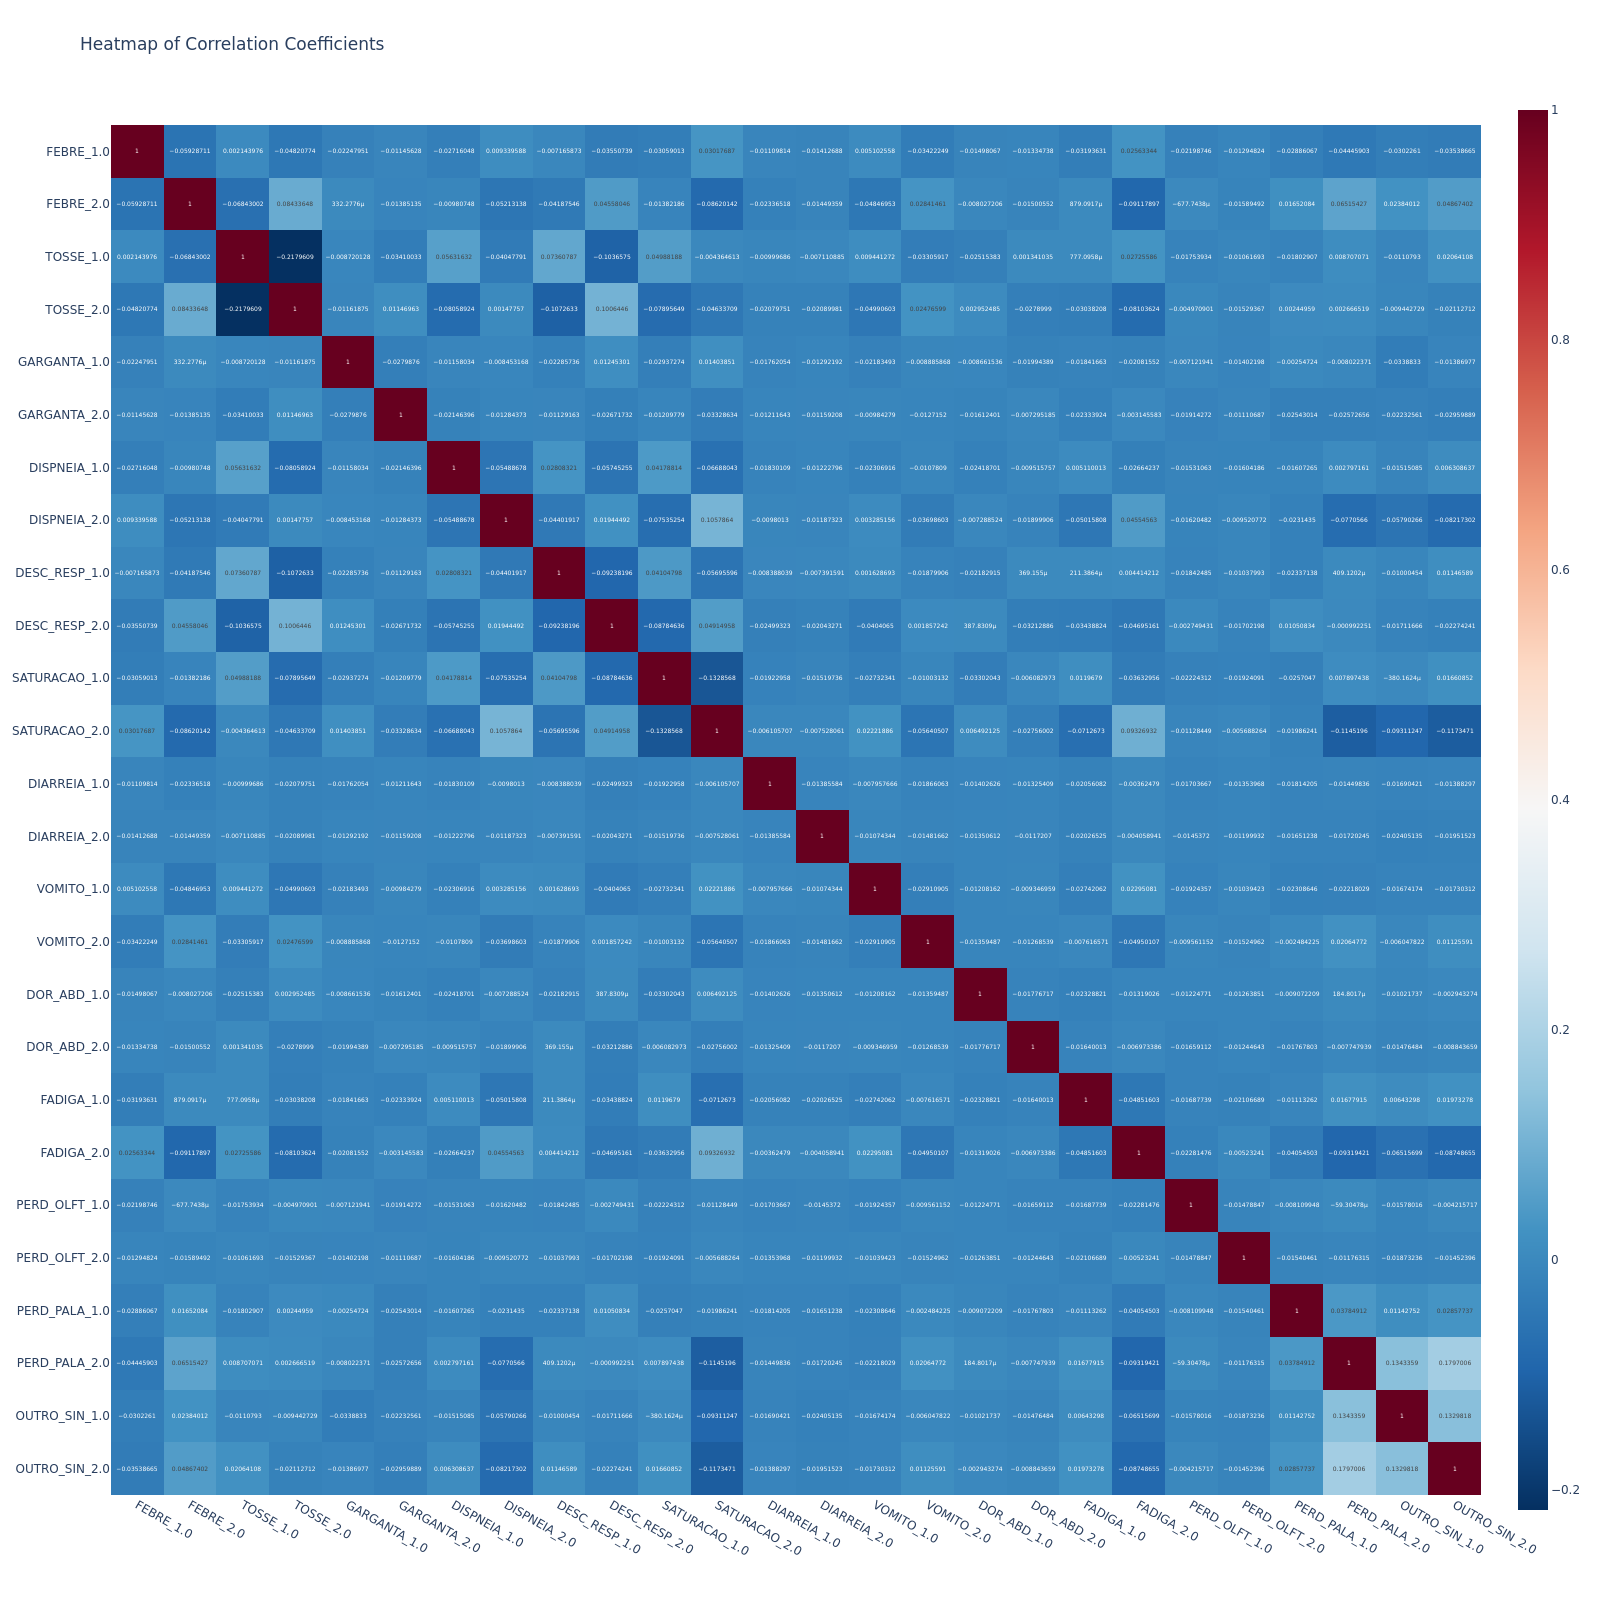

In [17]:
corr_heatmap(df.corr(numeric_only=True)[dummy_sintomas], fig_type="png")

# Fatores de Risco

In [18]:
dummy_fatores_risco = []
for fator in fatores_risco:
    dummy = df.columns[df.columns.str.startswith(fator)]
    dummy_fatores_risco = dummy_fatores_risco + dummy.tolist()

residuals_mapping = create_residuals_mapping(dummy_fatores_risco)
residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.90254317  0.04674909 -0.03576806 ...  0.05938648  0.09745683
  0.09745683]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.03285647  0.05059253 -0.00960591 ... -0.00108233 -0.03285647
 -0.03285647]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01386173 0.51215461 0.27193595 ... 0.19918546 0.01386173 0.01386173]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/262250446.py:6

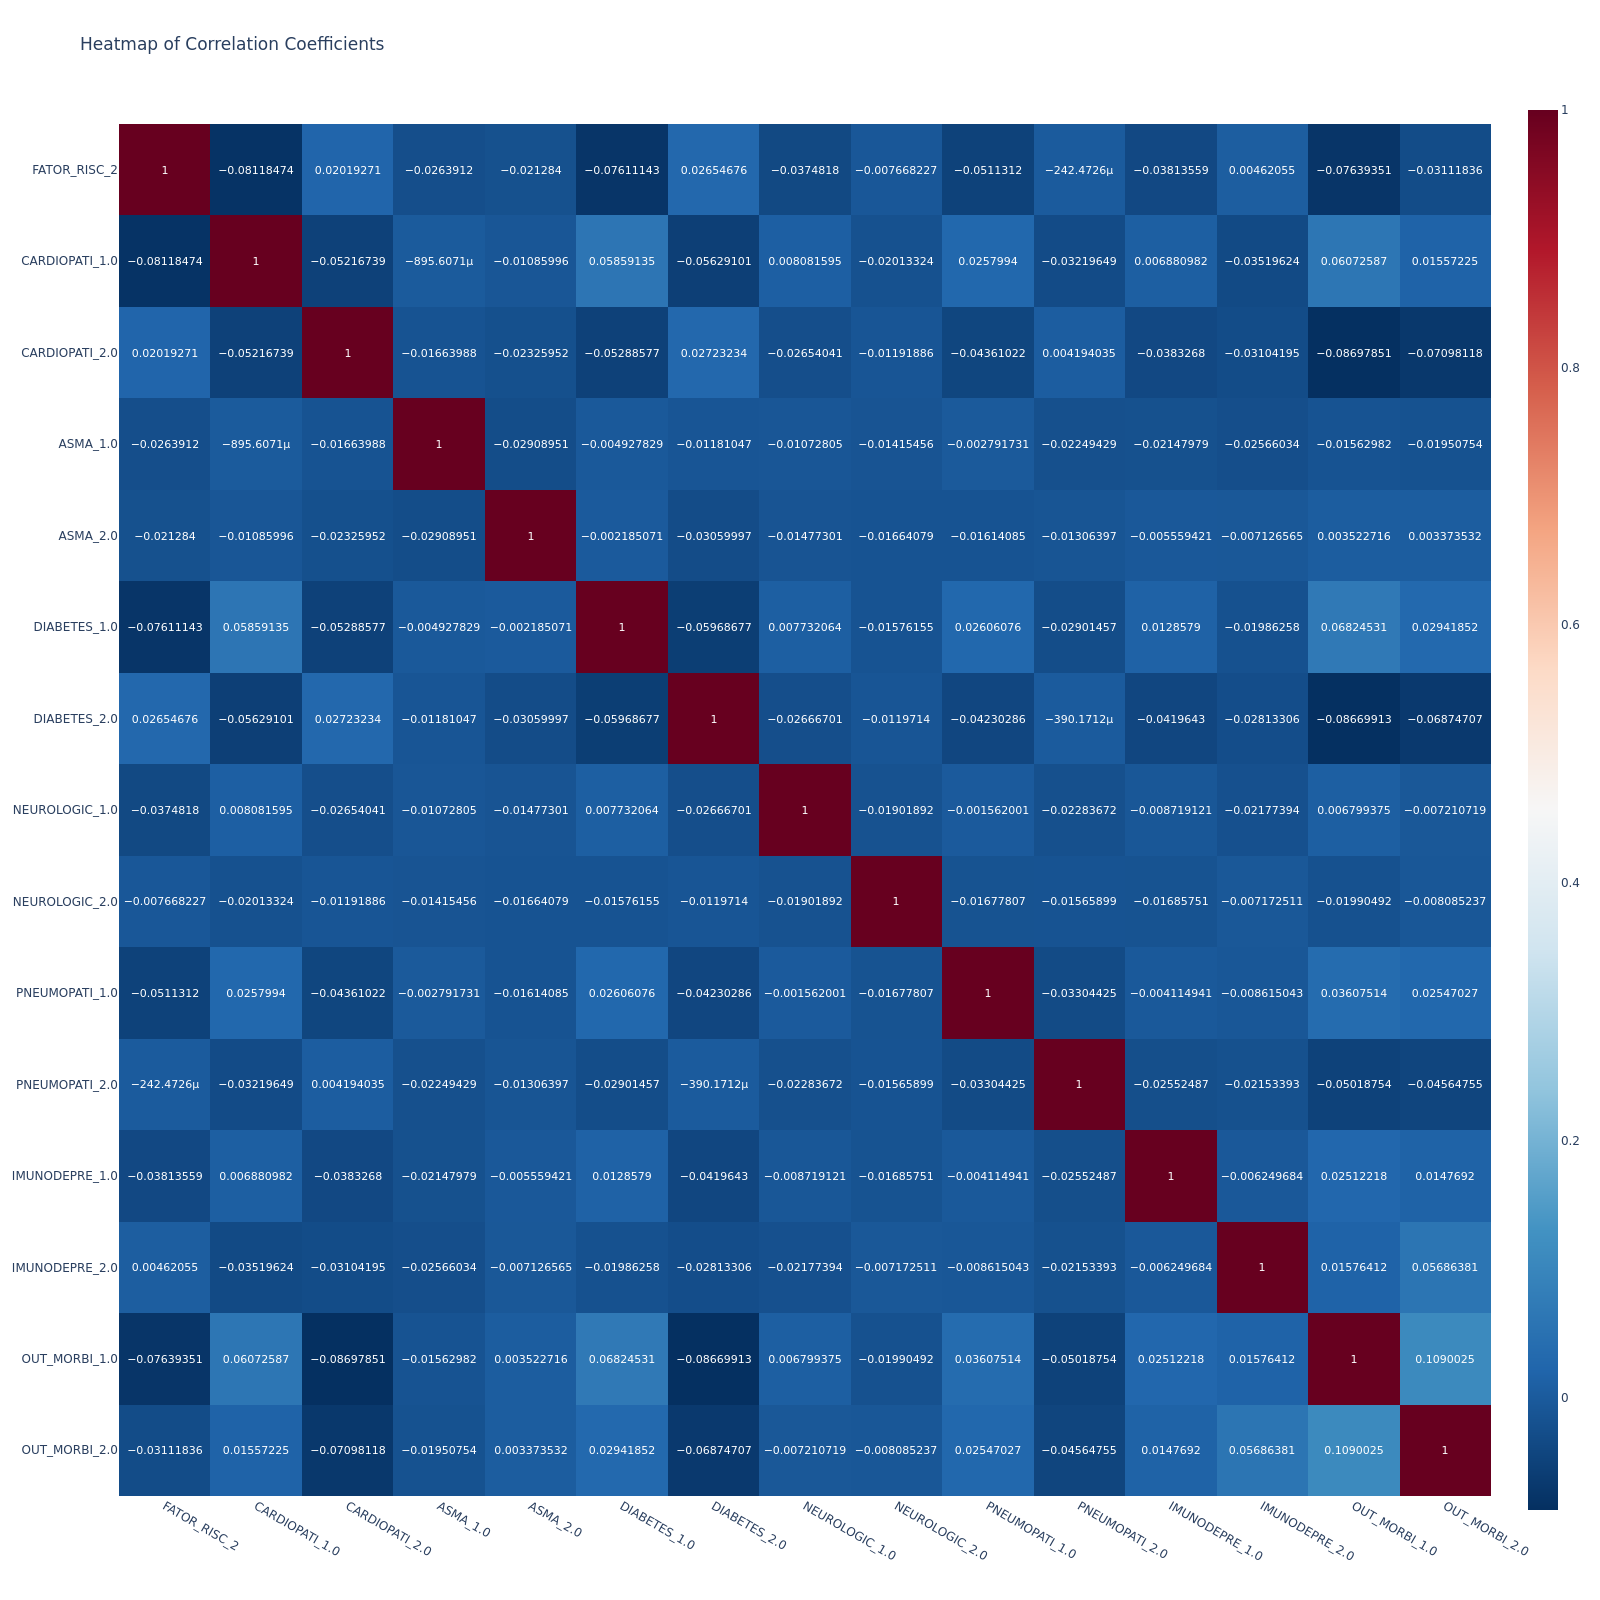

In [19]:
corr_heatmap(df.corr(numeric_only=True)[dummy_fatores_risco], fig_type="png")

# Internação

In [20]:
dummy_internacao = []
for inter in internacao:
    dummy = df.columns[df.columns.str.startswith(inter)]
    dummy_internacao = dummy_internacao + dummy.tolist()

residuals_mapping = create_residuals_mapping(dummy_internacao)
residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.00892643  0.00892643  0.00915463 ... -0.00106205  0.00892643
 -0.00106205]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.02491175 -0.02491175 -0.00116857 ...  0.00596776 -0.02491175
  0.00596776]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.28691249  0.28691249  0.09243798 ... -0.03997167  0.28691249
 -0.03997167]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_92850/2622504

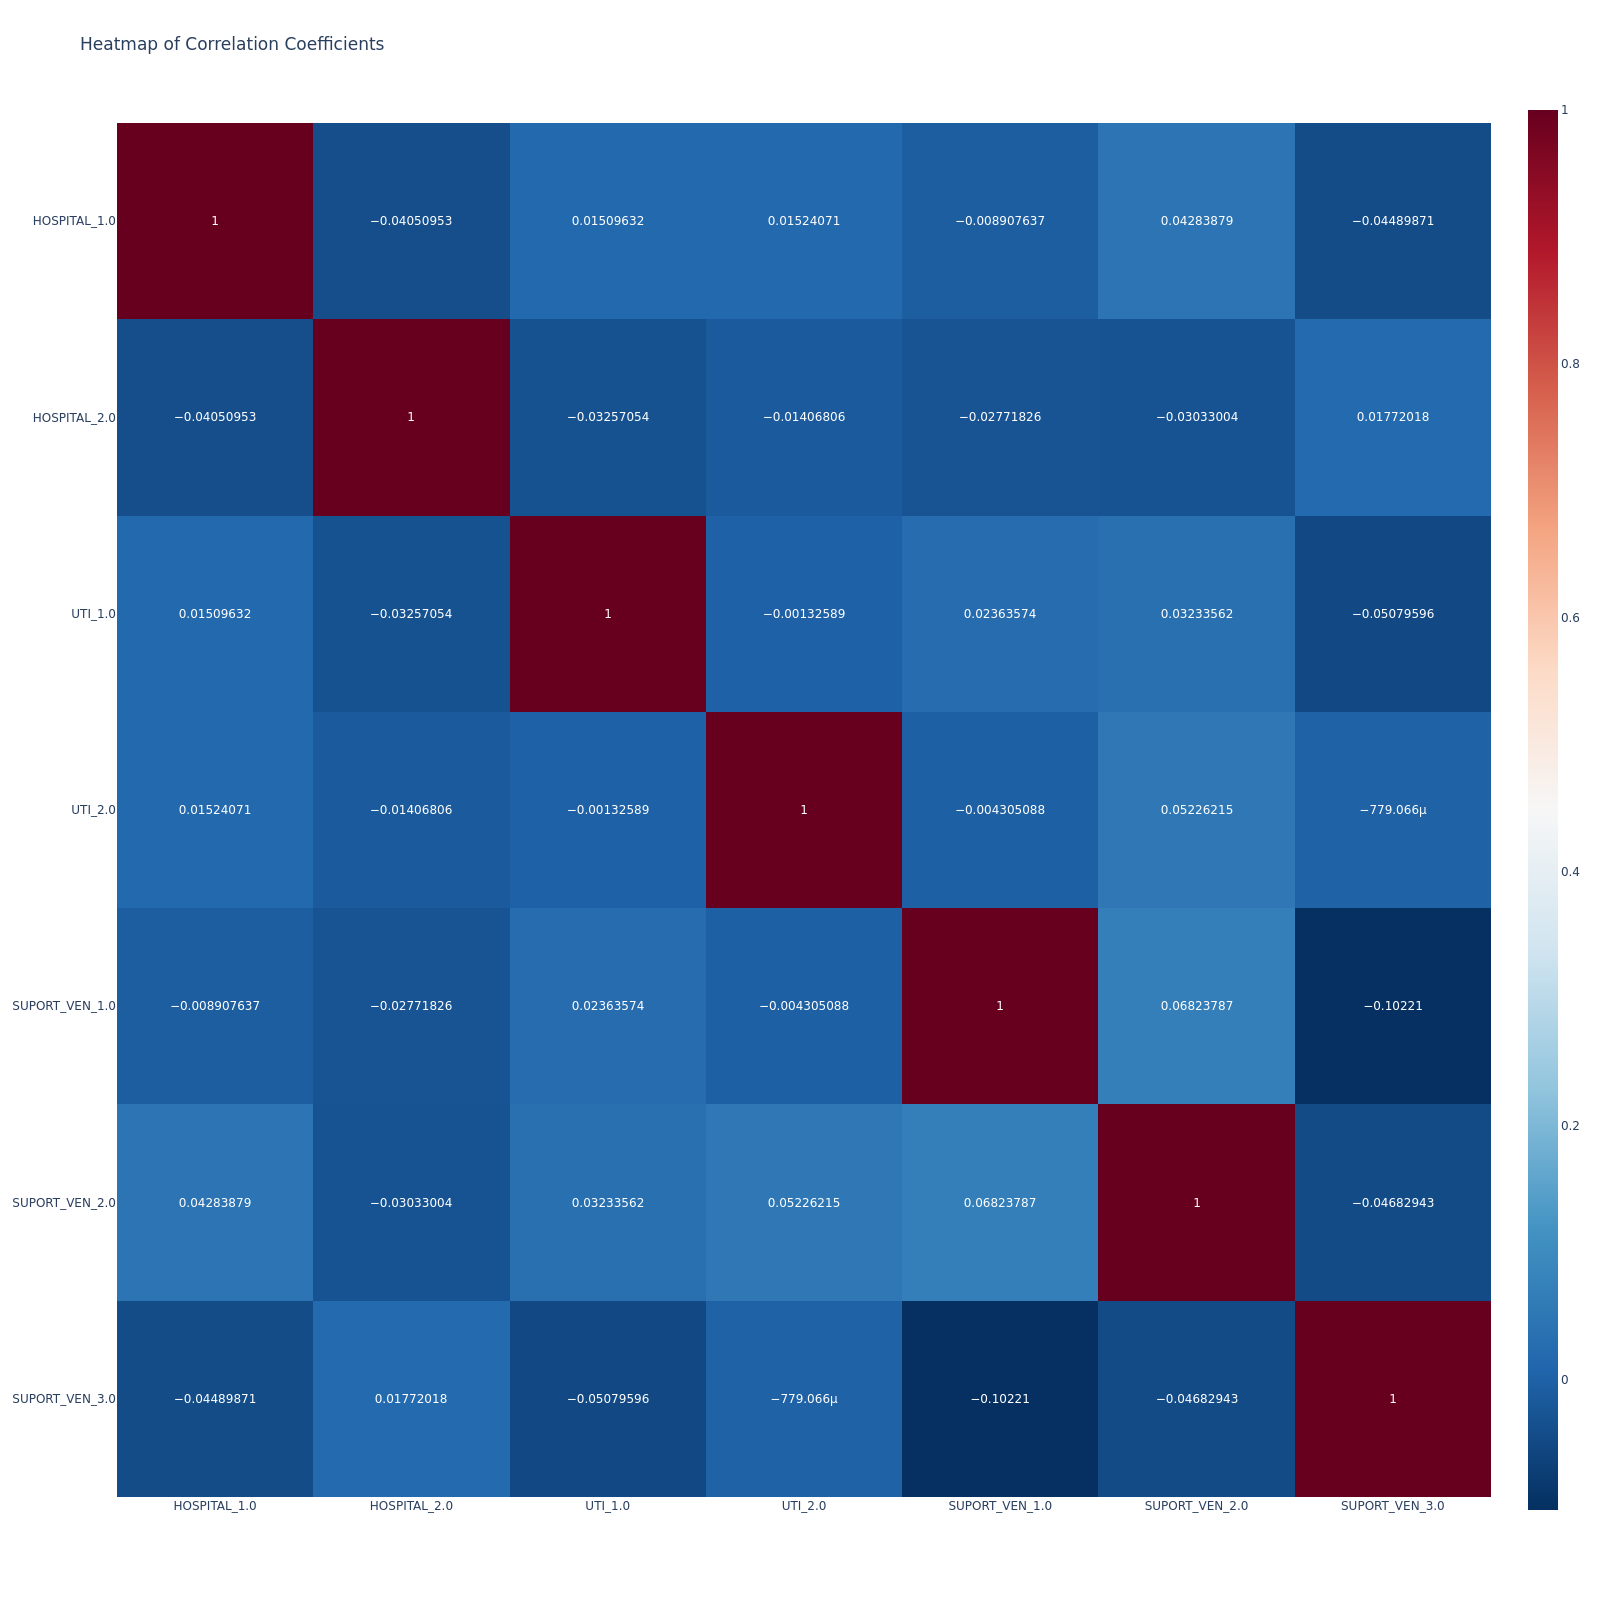

In [21]:
corr_heatmap(df.corr(numeric_only=True)[dummy_internacao], fig_type="png")

# Heatmap

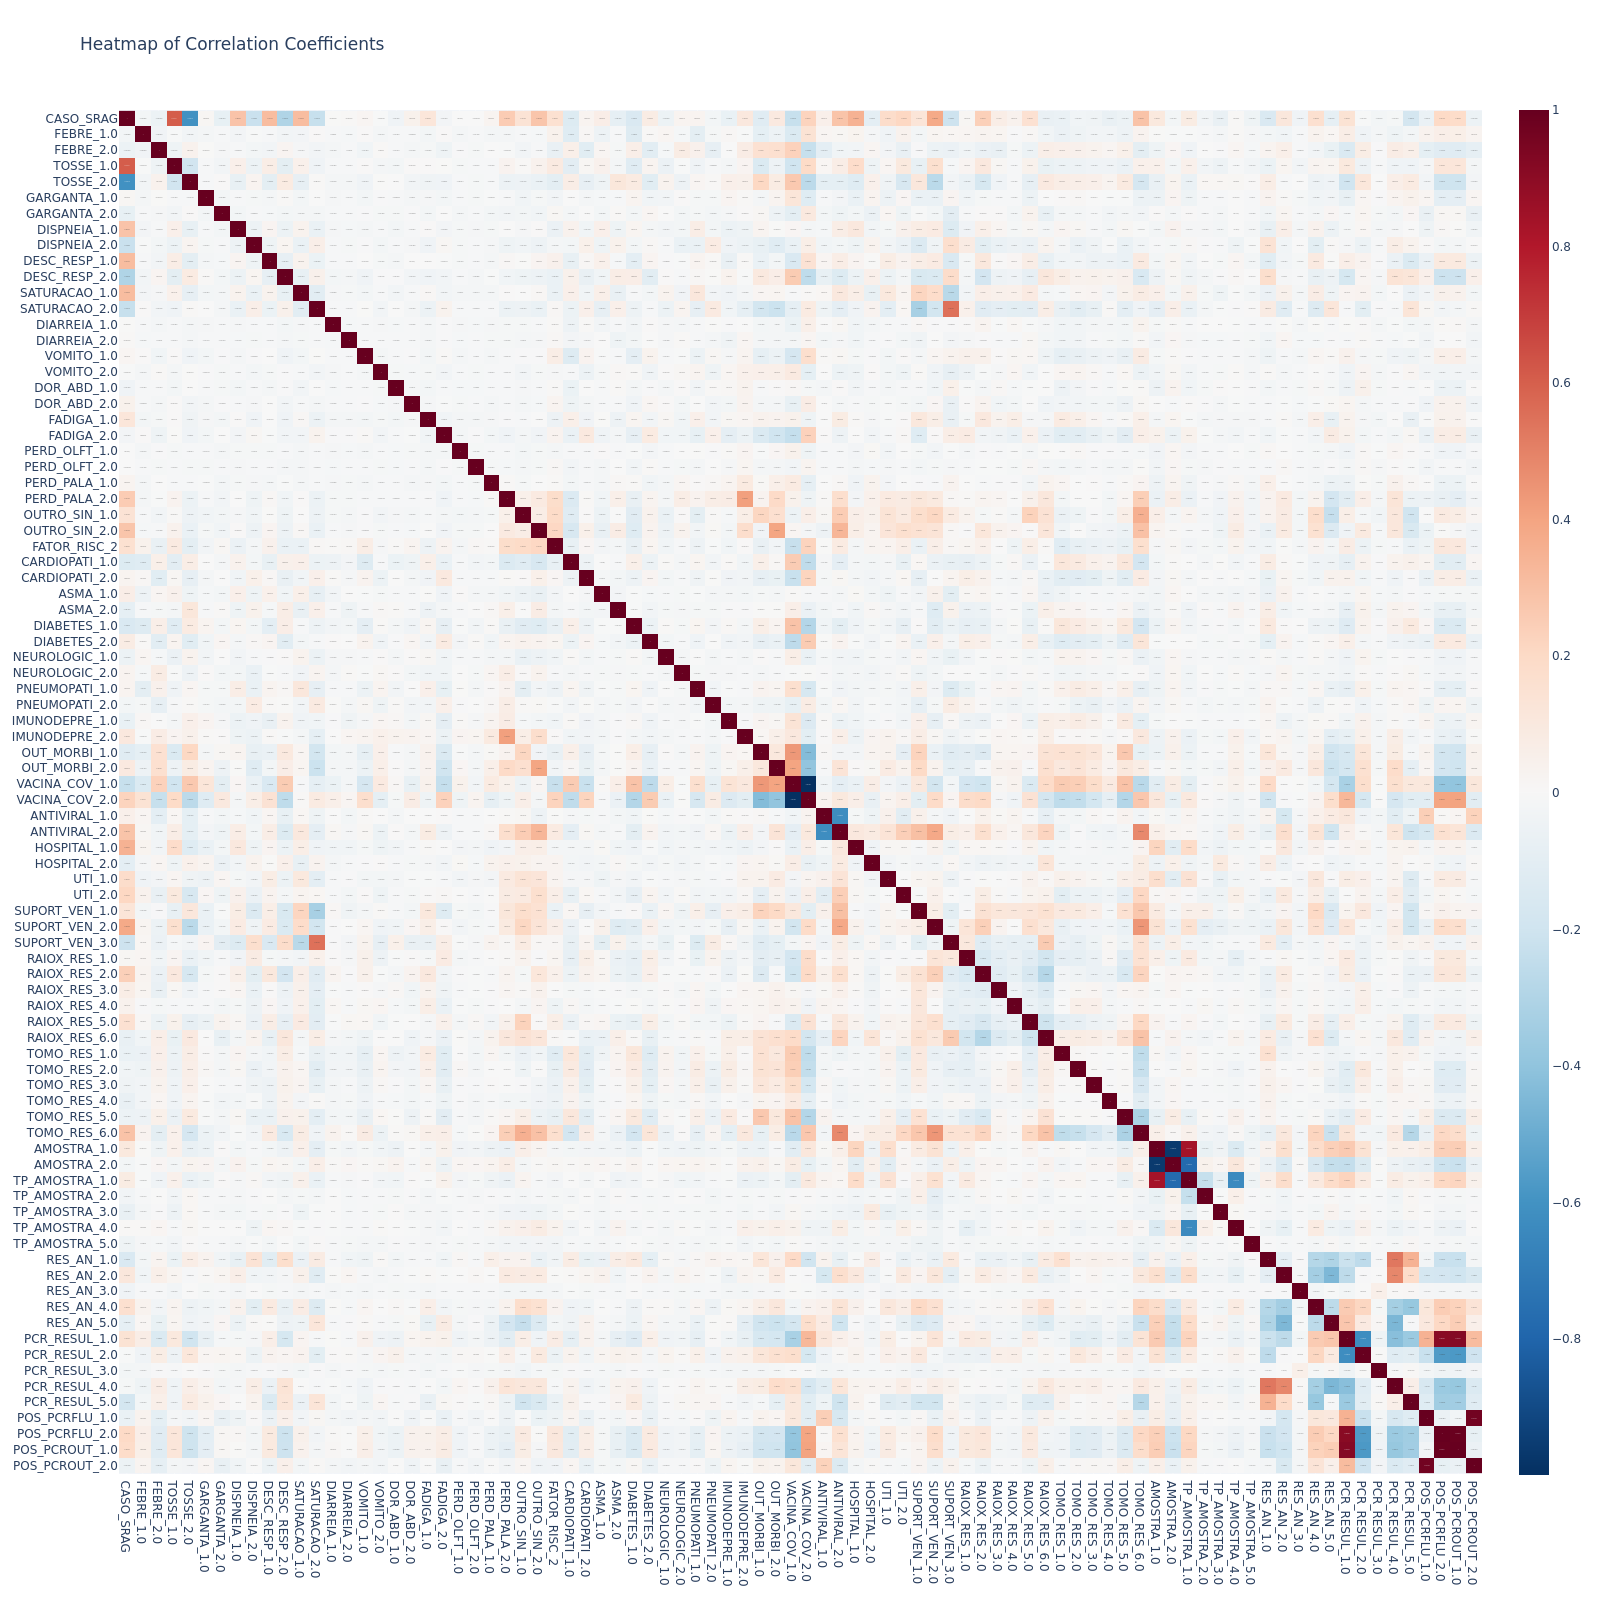

In [22]:
corr_heatmap(df.corr(numeric_only=True), fig_type="png")

In [23]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in tqdm(range(features.shape[0])):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [24]:
_, sample = train_test_split(df, test_size=0.3, random_state=42)
_, sample = train_test_split(sample, test_size=0.3, random_state=42)

In [25]:
#mask_features = filtering_features_based_on_vif(sample[df.columns.drop("CASO_SRAG")].astype(float), threshold=5)
#filtered_features = np.asarray(df.columns.drop("CASO_SRAG"))[mask_features]

In [26]:
#filtered_features

In [27]:
filtered_features = ['FEBRE_1.0', 'FEBRE_2.0', 'TOSSE_1.0', 'TOSSE_2.0', 'GARGANTA_1.0',
       'GARGANTA_2.0', 'DISPNEIA_1.0', 'DISPNEIA_2.0', 'DESC_RESP_1.0',
       'DESC_RESP_2.0', 'SATURACAO_1.0', 'SATURACAO_2.0', 'DIARREIA_1.0',
       'DIARREIA_2.0', 'VOMITO_1.0', 'VOMITO_2.0', 'DOR_ABD_1.0',
       'DOR_ABD_2.0', 'FADIGA_1.0', 'FADIGA_2.0', 'PERD_OLFT_1.0',
       'PERD_OLFT_2.0', 'PERD_PALA_1.0', 'PERD_PALA_2.0', 'OUTRO_SIN_1.0',
       'OUTRO_SIN_2.0', 'FATOR_RISC_2', 'CARDIOPATI_1.0',
       'CARDIOPATI_2.0', 'ASMA_1.0', 'ASMA_2.0', 'DIABETES_1.0',
       'DIABETES_2.0', 'NEUROLOGIC_1.0', 'NEUROLOGIC_2.0',
       'PNEUMOPATI_1.0', 'PNEUMOPATI_2.0', 'IMUNODEPRE_1.0',
       'IMUNODEPRE_2.0', 'OUT_MORBI_1.0', 'OUT_MORBI_2.0',
       'VACINA_COV_1.0', 'ANTIVIRAL_1.0', 'ANTIVIRAL_2.0', 'HOSPITAL_1.0',
       'HOSPITAL_2.0', 'UTI_1.0', 'UTI_2.0', 'SUPORT_VEN_1.0',
       'SUPORT_VEN_2.0', 'SUPORT_VEN_3.0', 'RAIOX_RES_1.0',
       'RAIOX_RES_2.0', 'RAIOX_RES_3.0', 'RAIOX_RES_4.0', 'RAIOX_RES_5.0',
       'RAIOX_RES_6.0', 'TOMO_RES_1.0', 'TOMO_RES_2.0', 'TOMO_RES_3.0',
       'TOMO_RES_4.0', 'TOMO_RES_5.0', 'TOMO_RES_6.0', 'AMOSTRA_2.0',
       'TP_AMOSTRA_2.0', 'TP_AMOSTRA_3.0', 'TP_AMOSTRA_4.0',
       'TP_AMOSTRA_5.0', 'RES_AN_1.0', 'RES_AN_2.0', 'RES_AN_3.0',
       'RES_AN_4.0', 'RES_AN_5.0', 'PCR_RESUL_2.0', 'PCR_RESUL_3.0',
       'PCR_RESUL_4.0', 'PCR_RESUL_5.0', 'POS_PCRFLU_1.0',
       'POS_PCRFLU_2.0', 'POS_PCROUT_2.0']

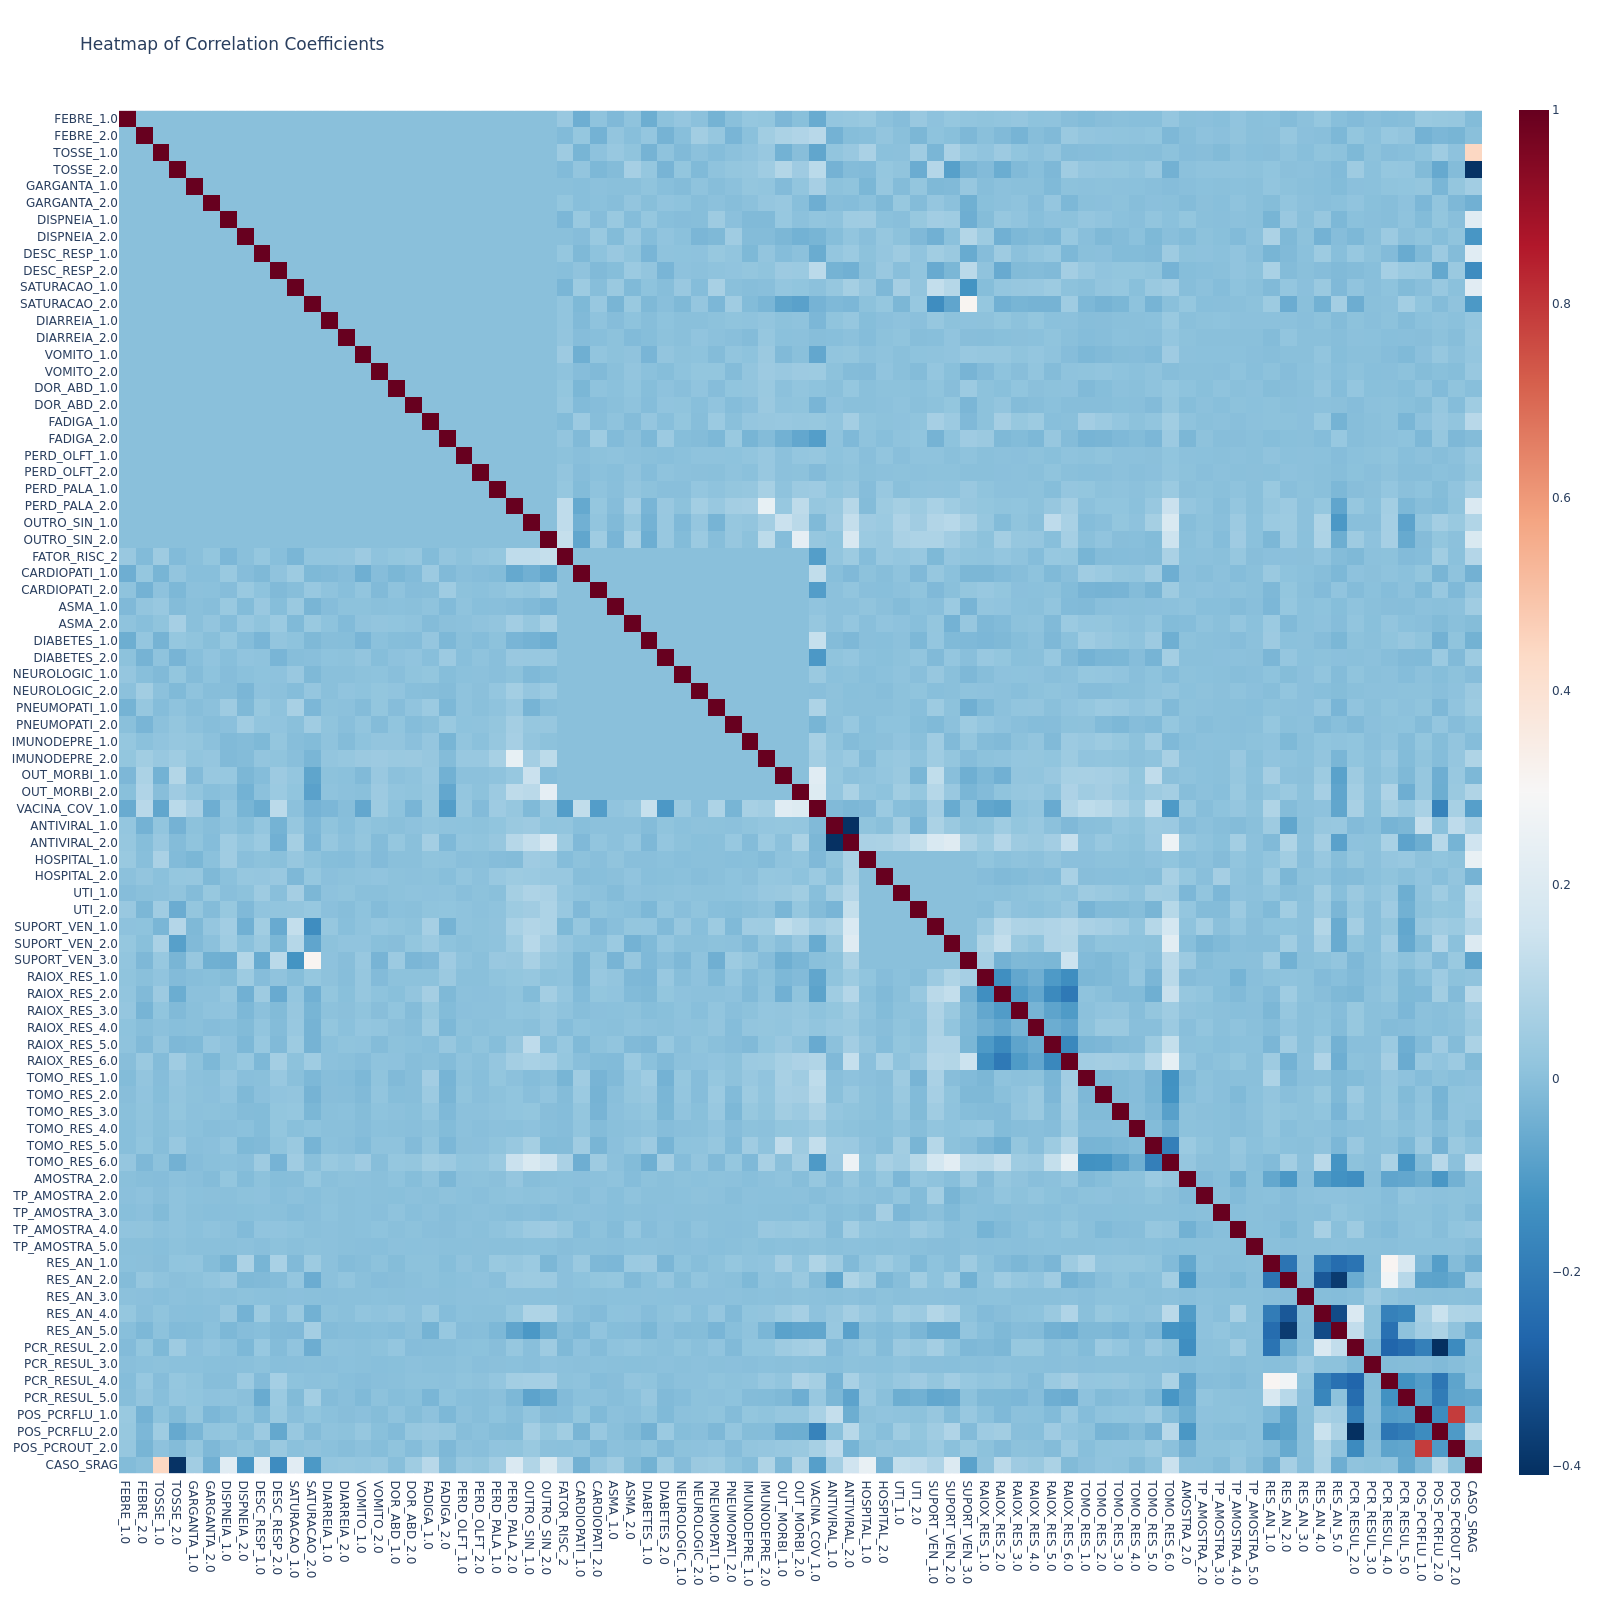

In [29]:
corr_heatmap(df[filtered_features + [target]], width=1600, height=1600, fig_type="png")

In [30]:
def plot_barplot_corr_with_target(df, target):
    corr = df.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

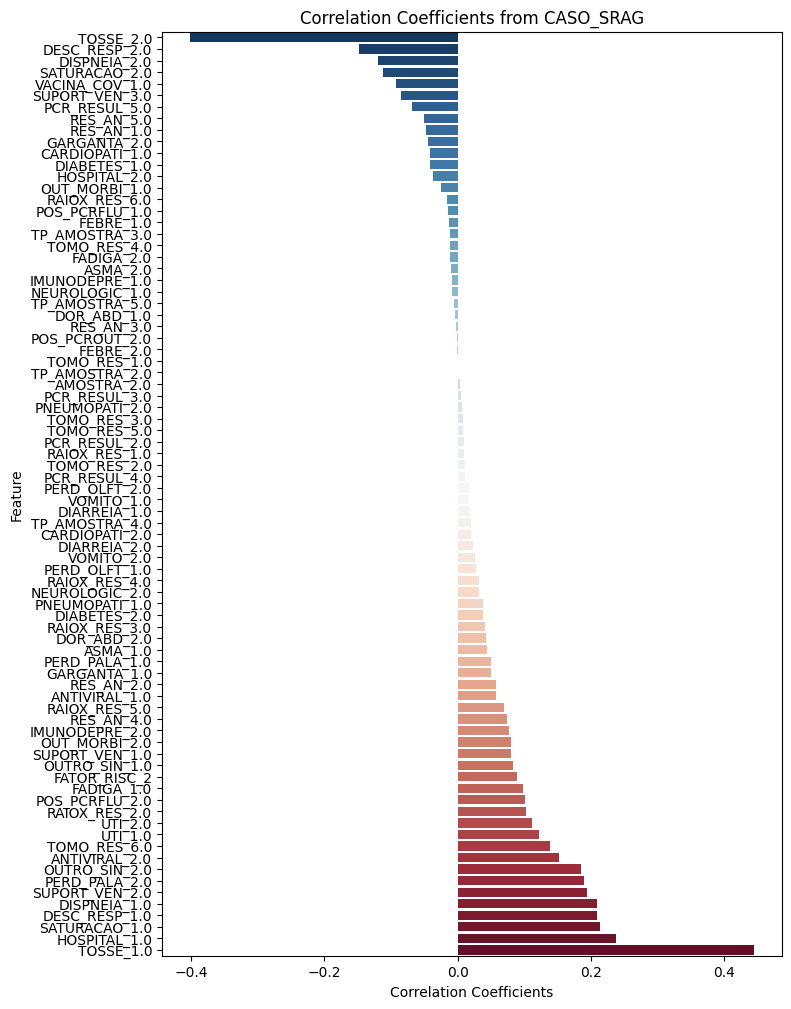

In [32]:
plot_barplot_corr_with_target(df[filtered_features + [target]], "CASO_SRAG")

# Modelling

In [33]:
model = LogisticRegression(class_weight="balanced")

In [34]:
df[target].value_counts()

CASO_SRAG
 1    178224
 0     59125
-1     29081
Name: count, dtype: int64

In [35]:
df_blind_test = df[(df["CASO_SRAG"] == -1)]
df = df[(df["CASO_SRAG"] > -1)]

In [36]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [37]:
model = TunedThresholdClassifierCV(
    model, scoring="matthews_corrcoef"
).fit(df_train[filtered_features], df_train[target])

In [39]:
matthews_corrcoef(df_test[target], model.predict(df_test[filtered_features]))

0.9686632500487301

In [40]:
model.best_threshold_

0.33333332093841556

In [42]:
def cm(clf, X, y, fig_type=None, percentage_by_class=True):
    """
    Generates an annotated heatmap of the confusion matrix for a classifier.

    Args:
        clf: Classifier object (e.g., sklearn classifier).
        X: Input features.
        y: True labels.
        alpha: Optional parameter for classifier prediction.
        fig_type: Optional figure type (e.g., 'png', 'svg').
        percentage_by_class: If True, displays percentages by class; otherwise, overall percentages.

    Returns:
        Annotated heatmap of the confusion matrix.
    """

    y_pred = clf.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    labels = np.array([["FN", "TN"], ["TP", "FP"]])
    cm = np.array([[fn, tn], [tp, fp]])

    if percentage_by_class:
        total = cm.sum(axis=0)
        percentage = cm / total * 100
    else:
        percentage = cm / np.sum(cm) * 100

    annotation_text = np.empty_like(percentage, dtype="U10")

    for i in range(percentage.shape[0]):
        for j in range(percentage.shape[1]):
            annotation_text[i, j] = f"{labels[i, j]} {percentage[i, j]:.2f}"

    fig = ff.create_annotated_heatmap(
        cm,
        x=["Positive", "Negative"],
        y=["Negative", "Positive"],
        colorscale="Blues",
        hoverinfo="z",
        annotation_text=annotation_text,
    )

    fig.update_layout(width=400, height=400, title="Confusion Matrix")
    return fig.show(fig_type)

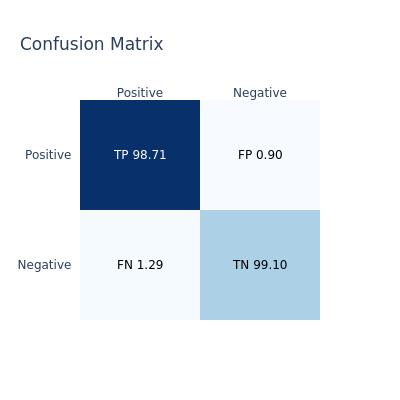

In [43]:
cm(model, df_test[filtered_features], df_test[target], fig_type="png")

## Análise de resíduo